<a href="https://colab.research.google.com/github/Rahul-dsml/Myprojects/blob/main/Flower_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
!pip install kaggle

In [10]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [11]:
! chmod 600 ~/.kaggle/kaggle.json

In [12]:
! kaggle datasets download alxmamaev/flowers-recognition

 92% 207M/225M [00:01<00:00, 117MB/s]
100% 225M/225M [00:01<00:00, 126MB/s]


In [ ]:
!unzip flowers-recognition.zip
!rm flowers-recognition.zip

In [14]:
from skimage import io
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import random

In [15]:
DATASET_PATH = './flowers'
flowers_cls = ['daisy', 'rose']

In [16]:
# globbing example
# help(glob)
flower_path = os.path.join(DATASET_PATH, flowers_cls[1], '*')
print(flower_path)

# glob through the directory (returns a list of all file paths)
flower_path = glob.glob(flower_path)
print(flower_path[3]) # access an individual file

./flowers/rose/*
./flowers/rose/14880561916_79aeb812fd_n.jpg


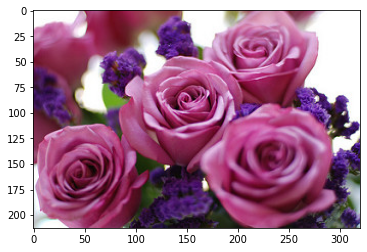

In [17]:
# run this block multiple times to look at some randomly chosen images of roses
rand_index = random.randint(0, len(flower_path))
image = io.imread(flower_path[rand_index])
plt.imshow(image)

In [18]:
print(image.shape)

(213, 320, 3)


Text(0.5, 0.98, 'Different Channels of Image')

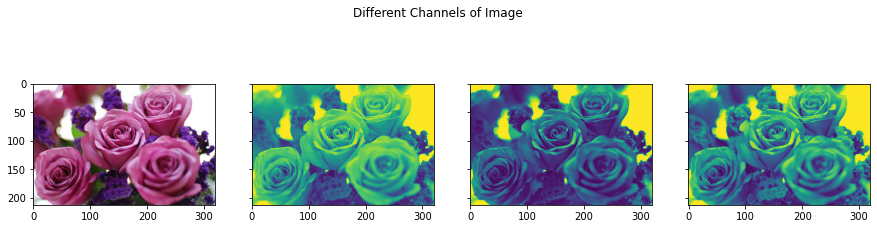

In [19]:
# plotting the original image and the RGB channels
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey=True)
f.set_figwidth(15)
ax1.imshow(image)

# RGB channels
ax2.imshow(image[:, : , 0])
ax3.imshow(image[:, : , 1])
ax4.imshow(image[:, : , 2])
f.suptitle('Different Channels of Image')

In [20]:
# function to plot n images using subplots
def plot_image(images, captions=None, cmap=None ):
    f, axes = plt.subplots(1, len(images), sharey=True)
    f.set_figwidth(15)
    for ax,image in zip(axes, images):
        ax.imshow(image, cmap)

## Thresholding

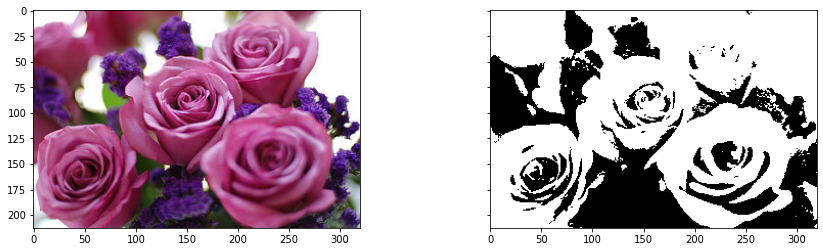

In [21]:
binary_image= image[:,:,0]>125
plot_image([image, binary_image], cmap='gray')

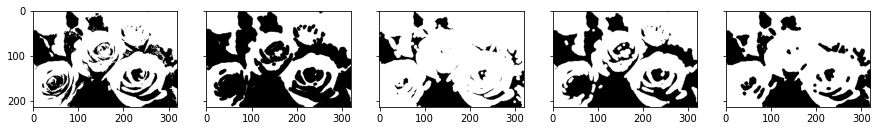

In [22]:
from skimage.morphology import binary_erosion, binary_dilation, binary_opening, binary_closing
from skimage.morphology import selem

selem= selem.disk(3)

open_img= binary_opening(binary_image, selem)
close_img= binary_closing(binary_image, selem)
ero_img= binary_erosion(binary_image, selem)
dil_img= binary_dilation(binary_image, selem)

plot_image([binary_image, ero_img, dil_img, open_img, close_img], cmap='gray')

### Normalization

In [23]:
image= image/255
image

array([[[1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        ...,
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ]],

       [[1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        ...,
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ]],

       [[1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        ...,
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ]],

       ...,

       [[0.76470588, 0.76470588, 0.79607843],
        [0.76862745, 0.78431373, 0.79607843],
        [0.78039216, 0

### Transformations

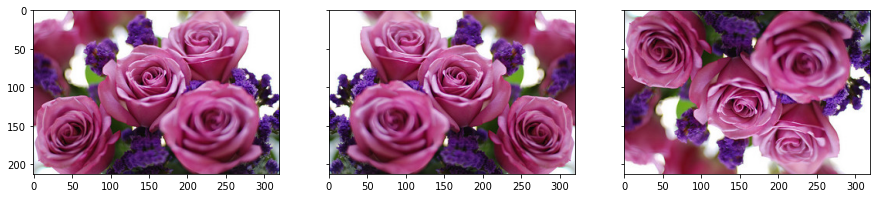

In [24]:
img_fliplr= np.fliplr(image)
img_flipud= np.flipud(image)
plot_image([image, img_fliplr, img_flipud])

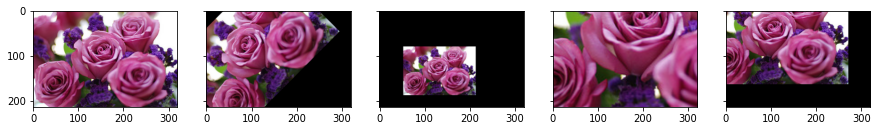

In [25]:
from skimage import transform

# specify x and y coordinates to be used for shifting (mid points)
shift_x, shift_y = image.shape[0]/2, image.shape[1]/2

# translation by certain units
matrix_to_topleft = transform.SimilarityTransform(translation=[-shift_x, -shift_y])
matrix_to_center = transform.SimilarityTransform(translation=[shift_x, shift_y])

# rotation
rot_transforms =  transform.AffineTransform(rotation=np.deg2rad(45))
rot_matrix = matrix_to_topleft + rot_transforms + matrix_to_center
rot_image = transform.warp(image, rot_matrix)

# scaling 
scale_transforms = transform.AffineTransform(scale=(2, 2))
scale_matrix = matrix_to_topleft + scale_transforms + matrix_to_center
scale_image_zoom_out = transform.warp(image, scale_matrix)

scale_transforms = transform.AffineTransform(scale=(0.5, 0.5))
scale_matrix = matrix_to_topleft + scale_transforms + matrix_to_center
scale_image_zoom_in = transform.warp(image, scale_matrix)

# translation
transaltion_transforms = transform.AffineTransform(translation=(50, 50))
translated_image = transform.warp(image, transaltion_transforms)


plot_image([image, rot_image, scale_image_zoom_out, scale_image_zoom_in, translated_image])

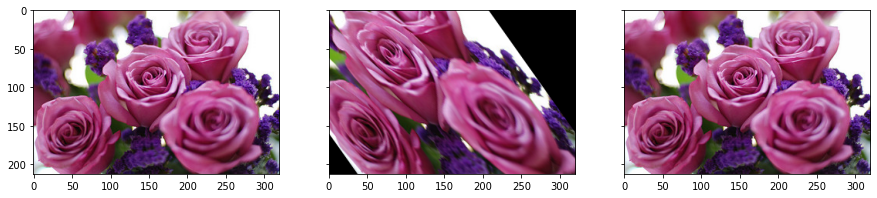

In [26]:
# shear transforms
shear_transforms = transform.AffineTransform(shear=np.deg2rad(45))
shear_matrix = matrix_to_topleft + shear_transforms + matrix_to_center
shear_image = transform.warp(image, shear_matrix)

bright_jitter = image*0.999 + np.zeros_like(image)*0.001

plot_image([image, shear_image, bright_jitter])

Model Building

In [28]:
import resnet

img_rows= 100
img_cols= 100
img_channels= 3
nb_classes= 2

In [29]:
import numpy as np
import tensorflow as tf

class DataGenerator(tf.keras.utils.Sequence):

  def __init__(self, mode= 'train', ablation=None, flower_cls= ['daisy', 'rose'],
               dim= (100, 100), batch_size= 32, n_channels= 3, shuffle=True):
    self.dim= dim
    self.batch_size= batch_size
    self.list_IDs= []
    self.labels= {}

    for i, cls in enumerate(flower_cls):
      paths= glob.glob(os.path.join(DATASET_PATH, cls, '*'))
      brk_point= int(len(paths) * 0.8)
      if mode== 'train':
        paths= paths[:brk_point]
      else:
        paths= paths[brk_point:]
      
      if ablation is not None:
        paths= paths[: ablation]
      self.list_IDs += paths
      self.labels.update({p:i for p in paths})

    self.n_channels= n_channels
    self.n_classes= len(flower_cls)
    self.shuffle= shuffle
    self.on_epoch_end()

  def on_epoch_end(self):
    self.indexes= np.arange(len(self.list_IDs))
    if self.shuffle== True:
      np.random.shuffle(self.indexes)

  def __len__(self):
      'Denotes the number of batches per epoch'
      return int(np.floor(len(self.list_IDs) / self.batch_size))
    
  def __getitem__(self, index):
    indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

    # Find list of IDs
    list_IDs_temp = [self.list_IDs[k] for k in indexes]

    # Generate data
    X, y = self.__data_generation(list_IDs_temp)

    return X, y

  def __data_generation(self, list_IDs_temp):
    #Initialization
    X= np.empty((self.batch_size, *self.dim, self.n_channels))
    y= np.empty((self.batch_size), dtype=int)

    #delete rows having dimensions less than 100
    delete_rows=[]
    for i, ID in enumerate(list_IDs_temp):
      img= io.imread(ID)
      img= img/255
      
      if img.shape[0] > 100 and img.shape[1] > 100:
        h, w, _= img.shape
        img= img[int(h/2)-50:int(h/2)+50, int(w/2)-50: int(w/2)+50, :]
      else:
        delete_rows.append(i)
        continue

      X[i,]= img
      y[i]= self.labels[ID]

    X= np.delete(X, delete_rows, axis=0)
    y= np.delete(y, delete_rows, axis=0)

    return X, tf.keras.utils.to_categorical(y, num_classes= self.n_classes)

### Checking whether network is working or not

In [30]:
#using resnet_18
model= resnet.ResnetBuilder.build_resnet_18((img_channels, img_rows, img_cols), nb_classes)
model.compile(optimizer= 'SGD',
              loss= 'categorical_crossentropy',
              metrics= ['accuracy'])

training_generator= DataGenerator('train', ablation=100)
validation_generator= DataGenerator('val', ablation=100)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 50, 50, 64)   9472        ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 50, 50, 64)  256         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

In [31]:
model.fit(training_generator, epochs=1, validation_data=validation_generator)

6/6 [==============================] - 15s 463ms/step - loss: 1.6682 - accuracy: 0.4792 - val_loss: 5.2934 - val_accuracy: 0.5000


### Overfitting the data to see whether model is learning or not

In [32]:
model.fit(training_generator, epochs=20, validation_data= validation_generator)

Epoch 1/20
6/6 [==============================] - 2s 360ms/step - loss: 1.5981 - accuracy: 0.6458 - val_loss: 3.6478 - val_accuracy: 0.4896
Epoch 2/20
6/6 [==============================] - 2s 323ms/step - loss: 1.5392 - accuracy: 0.6979 - val_loss: 2.2526 - val_accuracy: 0.5469
Epoch 3/20
6/6 [==============================] - 2s 354ms/step - loss: 1.4948 - accuracy: 0.7552 - val_loss: 2.0171 - val_accuracy: 0.5625
Epoch 4/20
6/6 [==============================] - 2s 326ms/step - loss: 1.4625 - accuracy: 0.7656 - val_loss: 1.8364 - val_accuracy: 0.5833
Epoch 5/20
6/6 [==============================] - 2s 326ms/step - loss: 1.4383 - accuracy: 0.8333 - val_loss: 1.8377 - val_accuracy: 0.5885
Epoch 6/20
6/6 [==============================] - 2s 318ms/step - loss: 1.4112 - accuracy: 0.8073 - val_loss: 1.7375 - val_accuracy: 0.6250
Epoch 7/20
6/6 [==============================] - 2s 316ms/step - loss: 1.3943 - accuracy: 0.8125 - val_loss: 1.7090 - val_accuracy: 0.6406
Epoch 8/20
6/6 [====

### Training on full dataset

In [33]:
training_generator= DataGenerator(mode= 'train')
validation_generator= DataGenerator(mode= 'val')
history= model.fit(training_generator, epochs=25, validation_data= validation_generator)

Epoch 1/25
38/38 [==============================] - 8s 209ms/step - loss: 1.3589 - accuracy: 0.8204 - val_loss: 1.4206 - val_accuracy: 0.7812
Epoch 2/25
38/38 [==============================] - 8s 197ms/step - loss: 1.3353 - accuracy: 0.8369 - val_loss: 1.3952 - val_accuracy: 0.7986
Epoch 3/25
38/38 [==============================] - 7s 180ms/step - loss: 1.3257 - accuracy: 0.8427 - val_loss: 1.3951 - val_accuracy: 0.7951
Epoch 4/25
38/38 [==============================] - 7s 178ms/step - loss: 1.2985 - accuracy: 0.8600 - val_loss: 1.3704 - val_accuracy: 0.8264
Epoch 5/25
38/38 [==============================] - 7s 179ms/step - loss: 1.2846 - accuracy: 0.8616 - val_loss: 1.3994 - val_accuracy: 0.8021
Epoch 6/25
38/38 [==============================] - 7s 179ms/step - loss: 1.2698 - accuracy: 0.8764 - val_loss: 1.3905 - val_accuracy: 0.8056
Epoch 7/25
38/38 [==============================] - 7s 179ms/step - loss: 1.2577 - accuracy: 0.8847 - val_loss: 1.3640 - val_accuracy: 0.8090
Epoch 

### The model is overfitting

### Hyperparameters tuning

In [34]:
from tensorflow.python.ops.clip_ops import clip_by_norm
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import *

lr_list= [0.1, 0.01, 0.001, 0.0001]

class LossHistory(tf.keras.callbacks.Callback):

  def on_train_begin(self, logs={}):
    self.losses= []

  def on_epoch_end(self, epoch, logs= {}):
    self.losses.append(logs.get('loss'))

history= LossHistory()
plot_loss= {}

for lr in lr_list:
  print("Checking for learning rate= ", lr)
  sgd= optimizers.SGD(lr, clipnorm=1.)

  model= resnet.ResnetBuilder.build_resnet_18((img_channels, img_rows, img_cols), nb_classes)
  model.compile(optimizer=sgd,
                loss= 'categorical_crossentropy',
                metrics= ['accuracy'])
  train_generator= DataGenerator(mode= 'train', ablation= 200)
  valid_generator= DataGenerator(mode= 'val', ablation=200)

  model.fit(train_generator, epochs= 5, validation_data= valid_generator, callbacks= history) 
  plot_loss[lr]= history.losses

Checking for learning rate=  0.1
Epoch 1/5
12/12 [==============================] - 11s 355ms/step - loss: 1.5381 - accuracy: 0.7050 - val_loss: 5.0956 - val_accuracy: 0.5660
Epoch 2/5
12/12 [==============================] - 3s 282ms/step - loss: 1.4102 - accuracy: 0.7859 - val_loss: 3.5918 - val_accuracy: 0.5694
Epoch 3/5
12/12 [==============================] - 3s 282ms/step - loss: 1.3344 - accuracy: 0.8281 - val_loss: 2.9101 - val_accuracy: 0.6111
Epoch 4/5
12/12 [==============================] - 3s 282ms/step - loss: 1.2907 - accuracy: 0.8538 - val_loss: 1.7426 - val_accuracy: 0.6597
Epoch 5/5
12/12 [==============================] - 3s 283ms/step - loss: 1.2184 - accuracy: 0.8930 - val_loss: 1.5612 - val_accuracy: 0.7222
Checking for learning rate=  0.01
Epoch 1/5
12/12 [==============================] - 10s 349ms/step - loss: 1.6033 - accuracy: 0.6057 - val_loss: 4.0280 - val_accuracy: 0.4931
Epoch 2/5
12/12 [==============================] - 3s 282ms/step - loss: 1.4904 - acc

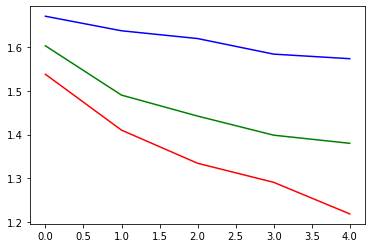

In [39]:
plt.plot(plot_loss[0.1], color= 'red')
plt.plot(plot_loss[0.01], color='green')
plt.plot(plot_loss[0.001], color= 'blue')

The above experiment shows better results for learning rate= 0.1.
However, this is high learning rate which may not perform better on whole dataset.
Therefore, using decay learning rate function.

In [47]:
class DecayLr(tf.keras.callbacks.Callback):
  def __init__(self, base_lr= 0.001, decay_epoch=4):
    super(DecayLr, self).__init__()
    self.base_lr= base_lr
    self.decay_epoch= decay_epoch
    self.lr_history= []

  def on_train_begin(self, logs={}):
    tf.keras.backend.set_value(self.model.optimizer.lr, self.base_lr)

  def on_epoch_end(self, epoch, logs={}):
    new_lr= self.base_lr * (0.5 ** (epoch // self.decay_epoch))
    self.lr_history.append(tf.keras.backend.get_value(self.model.optimizer.lr))
    tf.keras.backend.set_value(self.model.optimizer.lr, new_lr)

history= LossHistory()
plot_data={}

decay= DecayLr(base_lr= 0.1)
sgd= optimizers.SGD()

model= resnet.ResnetBuilder.build_resnet_18((img_channels, img_rows, img_cols), nb_classes)
model.compile(optimizer=sgd,
              loss= 'categorical_crossentropy',
              metrics= ['accuracy'])
training_generator= DataGenerator(mode='train', ablation= 200)
validation_generator= DataGenerator(mode= 'val', ablation= 200)

model.fit(training_generator, epochs= 10, validation_data= validation_generator, callbacks=[history, decay])
plot_data[lr]= decay.lr_history

Epoch 1/10
12/12 [==============================] - 7s 345ms/step - loss: 1.7207 - accuracy: 0.6554 - val_loss: 5.7810 - val_accuracy: 0.5868
Epoch 2/10
12/12 [==============================] - 3s 275ms/step - loss: 1.4530 - accuracy: 0.7859 - val_loss: 1.6254 - val_accuracy: 0.7639
Epoch 3/10
12/12 [==============================] - 3s 266ms/step - loss: 1.3752 - accuracy: 0.8198 - val_loss: 1.7060 - val_accuracy: 0.6944
Epoch 4/10
12/12 [==============================] - 3s 267ms/step - loss: 1.4204 - accuracy: 0.7728 - val_loss: 4.2653 - val_accuracy: 0.5972
Epoch 5/10
12/12 [==============================] - 3s 278ms/step - loss: 1.4033 - accuracy: 0.8068 - val_loss: 1.6324 - val_accuracy: 0.7500
Epoch 6/10
12/12 [==============================] - 3s 268ms/step - loss: 1.1563 - accuracy: 0.9373 - val_loss: 1.5835 - val_accuracy: 0.7361
Epoch 7/10
12/12 [==============================] - 3s 259ms/step - loss: 1.1445 - accuracy: 0.9349 - val_loss: 1.5754 - val_accuracy: 0.7118
Epoch 

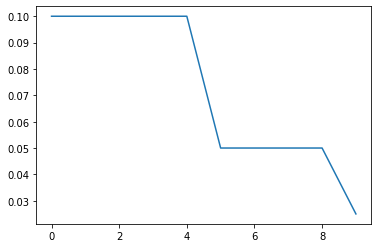

In [48]:
plt.plot(np.arange(len(decay.lr_history)), decay.lr_history)

### Applying data augmentation

In [50]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen= ImageDataGenerator(
    featurewise_center= True,
    featurewise_std_normalization= True,
    rotation_range= 20,
    width_shift_range= 0.2,
    horizontal_flip= True,
    height_shift_range=0.2

)

In [57]:
class AugmentedDataGenerator(tf.keras.utils.Sequence):

  def __init__(self, mode= 'train', ablation=None, flower_cls= ['daisy', 'rose'],
               dim= (100, 100), batch_size= 32, n_channels= 3, shuffle=True):
    self.dim= dim
    self.batch_size= batch_size
    self.list_IDs= []
    self.labels= {}
    self.mode= mode

    for i, cls in enumerate(flower_cls):
      paths= glob.glob(os.path.join(DATASET_PATH, cls, '*'))
      brk_point= int(len(paths) * 0.8)
      if mode== 'train':
        paths= paths[:brk_point]
      else:
        paths= paths[brk_point:]
      
      if ablation is not None:
        paths= paths[: ablation]
      self.list_IDs += paths
      self.labels.update({p:i for p in paths})

    self.n_channels= n_channels
    self.n_classes= len(flower_cls)
    self.shuffle= shuffle
    self.on_epoch_end()

  def on_epoch_end(self):
    self.indexes= np.arange(len(self.list_IDs))
    if self.shuffle== True:
      np.random.shuffle(self.indexes)

  def __len__(self):
      'Denotes the number of batches per epoch'
      return int(np.floor(len(self.list_IDs) / self.batch_size))
    
  def __getitem__(self, index):
    indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

    # Find list of IDs
    list_IDs_temp = [self.list_IDs[k] for k in indexes]

    # Generate data
    X, y = self.__data_generation(list_IDs_temp)

    return X, y

  def __data_generation(self, list_IDs_temp):
    #Initialization
    X= np.empty((self.batch_size, *self.dim, self.n_channels))
    y= np.empty((self.batch_size), dtype=int)

    #delete rows having dimensions less than 100
    delete_rows=[]
    for i, ID in enumerate(list_IDs_temp):
      img= io.imread(ID)
      img= img/255
      
      if img.shape[0] > 100 and img.shape[1] > 100:
        h, w, _= img.shape
        img= img[int(h/2)-50:int(h/2)+50, int(w/2)-50: int(w/2)+50, :]
      else:
        delete_rows.append(i)
        continue

      X[i,]= img
      y[i]= self.labels[ID]

    X= np.delete(X, delete_rows, axis=0)
    y= np.delete(y, delete_rows, axis=0)

    if self.mode== 'train':
      aug_x= np.stack([datagen.random_transform(img) for img in X])
      X= np.concatenate([X, aug_x])
      y= np.concatenate([y,y])

    return X, tf.keras.utils.to_categorical(y, num_classes= self.n_classes)

Using AUC-ROC metrics to optimize our model.

In [58]:

from sklearn.metrics import roc_auc_score

class roc_callback(Callback):
  def __init__(self, logs={}):
    logs['val_auc']= 0

  def on_epoch_end(self, epoch, logs={}):
    y_p=[]
    y_v=[]

    for i in range(len(validation_generator)):
      x_val, y_val= validation_generator[i]
      y_pred= self.model.predict(x_val)
      y_p.append(y_pred)
      y_v.append(y_val)

    y_p= np.concatenate(y_p)
    y_v= np.concatenate(y_v)
    score= roc_auc_score(y_v, y_p)
    print ('\nVal AUC for epoch{}: {}'.format(epoch, score))
    logs['val_auc'] = score


Running the model on whole dataset

In [59]:
model= resnet.ResnetBuilder.build_resnet_18((img_channels, img_rows, img_cols), nb_classes)
model.compile(optimizer= sgd,
              loss= 'categorical_crossentropy',
              metrics= ['accuracy'])
training_generator= AugmentedDataGenerator(mode= 'train')
validation_generator= AugmentedDataGenerator(mode= 'val')

auc_logger= roc_callback()

model.fit(training_generator, validation_data= validation_generator, epochs= 25, callbacks=[auc_logger, history, decay])

Epoch 1/25
38/38 [==============================] - ETA: 0s - loss: 1.5793 - accuracy: 0.7171
Val AUC for epoch0: 0.8382785738408839
38/38 [==============================] - 18s 378ms/step - loss: 1.5793 - accuracy: 0.7171 - val_loss: 1.7523 - val_accuracy: 0.7465 - val_auc: 0.8383
Epoch 2/25
38/38 [==============================] - ETA: 0s - loss: 1.4513 - accuracy: 0.7918
Val AUC for epoch1: 0.8201591511936339
38/38 [==============================] - 13s 329ms/step - loss: 1.4513 - accuracy: 0.7918 - val_loss: 1.8340 - val_accuracy: 0.7118 - val_auc: 0.8202
Epoch 3/25
38/38 [==============================] - ETA: 0s - loss: 1.3997 - accuracy: 0.8114
Val AUC for epoch2: 0.8632330246913581
38/38 [==============================] - 13s 330ms/step - loss: 1.3997 - accuracy: 0.8114 - val_loss: 1.7176 - val_accuracy: 0.7569 - val_auc: 0.8632
Epoch 4/25
38/38 [==============================] - ETA: 0s - loss: 1.3980 - accuracy: 0.8031
Val AUC for epoch3: 0.8948637569327225
38/38 [===========

Final Results:
Training Accuracy- 91.2%
Validation Accuracy- 84.4%
Validation_AUC- 92.24%